# Visualizing a Hybrid 2D Risk Scatter Plot

### Imports:

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib as Path

from scripts.AnomalyScoreDistribution import *

### Defining Hybrid Risk Scatter Surface Class:

In [3]:
class HybridRiskScatter:
    """
    Constructs and visualizes a hybrid 2D risk surface using both Autoencoder and Isolation Forest percentiles.
    This class is designed to operate on calibrated percentile scores.
    """
    
    def __init__(self, threshold_percentile: float=95.0, alpha: float=0.5, beta: float=0.5) -> None:
        """
        Initializes the Hybrid Risk Scatter.
        
        Args:
            threshold_percentile: The percentile used to define high-risk boundary
            alpha: The weight of AE percentile in hybrid score
            beta: The weight of IF percentile in hybrid score
            
        Returns:
            None:
        """
        self.threshold_percentile = threshold_percentile
        self.alpha = alpha
        self.beta = beta
        
        
    def build_dataframe(self, metadata: pd.DataFrame, ae_percentiles: np.ndarray, if_percentiles: np.ndarray) -> pd.DataFrame:
        """
        Constructs the hybrid risk DataFrame.
        
        Args:
            metadata: The metadata columns (e.g., (user, pc, day))
            ae_percentiles: The AE percentile scores
            if_percentiles: The IF percentile scores
            
        Returns:
            pd.DataFrame: A structured hybrid risk DataFrame
        """
        # Creating the DataFrame
        df = metadata.reset_index(drop=True).copy()
        df["ae_percentile"] = ae_percentiles
        df["if_percentile"] = if_percentiles
        
        # Computing the weighted hybrid risk score
        df["hybrid_score"] = ((self.alpha * df["ae_percentile"]) + (self.beta * df["if_percentile"]))
        
        # Assigning quadrant labels
        df["risk_quadrant"] = df.apply(self._assign_quadrant, axis=1)
        
        return df
    
    
    def _assign_quadrant(self, row: pd.Series) -> str:
        """
        Assigns the risk quadrant label.
        
        Args:
            row: The row of data that's being assigned a label
            
        Returns:
            str: The risk label
        """
        high_ae = row["ae_percentile"] >= self.threshold_percentile
        high_if = row["if_percentile"] >= self.threshold_percentile
        
        if high_ae and high_if:
            return "High AE / High IF"
        elif high_ae and not high_if:
            return "High AE / Low IF"
        elif not high_ae and high_if:
            return "Low AE / High IF"
        else:
            return "Low AE / Low IF"
        
        
    def plot_scatter(self, df: pd.DataFrame, save_path: str | None=None, title: str="Hybrid Risk Surface (AE vs. IF Percentiles)") -> None:
        """
        Plots a hybrid 2D risk scatter.
        
        Args:
            df: The DataFrame generated by `build_dataframe`
            title: The title to give the figure
            
        Returns:
            None:
        """
        plt.figure(figsize=(8,6))
        
        scatter = plt.scatter(
            x=df["ae_percentile"],
            y=df["if_percentile"],
            c=df["hybrid_score"],
            marker=".",
            cmap="coolwarm",
            # edgecolors="black",
            # linewidths=1,
            alpha=0.7
        )
        
        plt.axvline(self.threshold_percentile, linestyle="--", color=("k"))
        plt.axhline(self.threshold_percentile, linestyle="--", color=("k"))
        
        plt.colorbar(scatter, label="Hybrid Risk Score")
        plt.xlabel("AE Percentile")
        plt.ylabel("IF Percentile")
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        
        # Saves the figure if a save path is specified
        if save_path:
            save_dir = r"explainability\hybrid_risk_plot"
            save_path = os.path.join(save_dir, save_path)
            plt.savefig(save_path)
            
        plt.show()

### Computing AE and IF Percentiles:

In [5]:
# Importing alert dataset
alert_df = pd.read_csv(r"explainability\alert_table\alert_table_1.csv")

In [6]:
alert_df.head()

,user,pc,day,percentile_rank,risk_band,top_contributors,explanation
0,aab0162,pc-6599,2010-01-04,73.234835,LOW,"[('emails_sent', 0.3487802168561951), ('off_ho...",Behavior falls in the 73.23th percentile of re...
1,aab0162,pc-6599,2010-01-05,68.489343,LOW,"[('emails_sent', 0.2719235722699175), ('unique...",Behavior falls in the 68.49th percentile of re...
2,aab0162,pc-6599,2010-01-06,80.836852,MEDIUM,"[('emails_sent', 0.2582589955049517), ('unique...",Behavior falls in the 80.84th percentile of re...
3,aab0162,pc-6599,2010-01-07,70.978400,LOW,"[('emails_sent', 0.2865364371162134), ('off_ho...",Behavior falls in the 70.98th percentile of re...
4,aab0162,pc-6599,2010-01-08,73.272093,LOW,"[('emails_sent', 0.2967255021625118), ('attach...",Behavior falls in the 73.27th percentile of re...


In [7]:
# Extracting AE percentiles
ae_percentiles = alert_df["percentile_rank"].values

In [8]:
# Importing IF anomaly scores
anomaly_scores = np.load(r"isolation_forests\iforest_model_1\anomaly_scores.npy")

In [9]:
# Initializing and fitting the score distributer
dist_analyser = IsolationForestScoreDistribution()
dist_analyser.fit(anomaly_scores) 

In [10]:
# Computing IF percentiles
if_percentiles = np.array([dist_analyser.compute_percentile(score) for score in anomaly_scores])

### Plotting the Hybrid Risk Scatter:

In [11]:
hybrid_scatter = HybridRiskScatter(threshold_percentile=50)

In [12]:
hybrid_df = hybrid_scatter.build_dataframe(
    metadata=alert_df[["user", "pc", "day"]],
    ae_percentiles=ae_percentiles,
    if_percentiles=if_percentiles
)

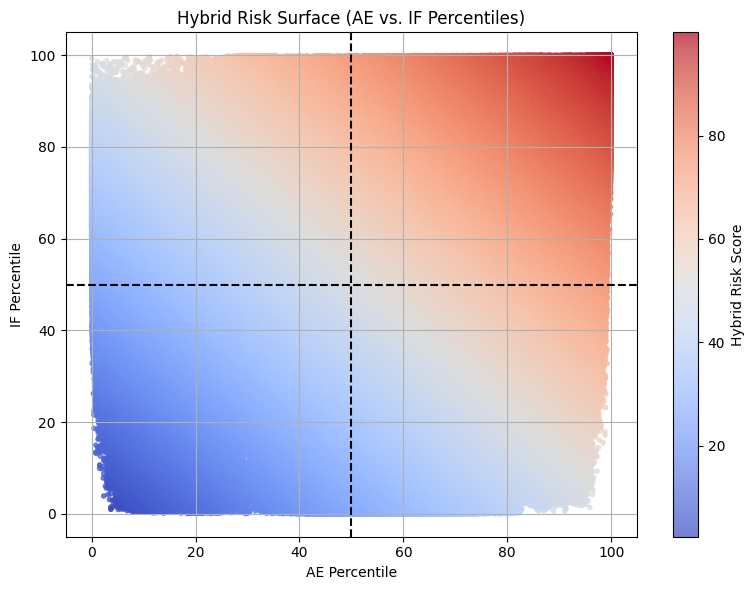

In [13]:
hybrid_scatter.plot_scatter(hybrid_df, save_path="hybrid_risk_plot_1.png")